In [10]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.tools import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit_machine_learning.kernels import QuantumKernel

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.neural_networks import CircuitQNN

In [3]:
# Construct teacher and student networks

from qiskit.circuit.library import RealAmplitudes

def student_network_builder(num_qubits):
    circuit = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cx', entanglement='linear', rotation_blocks=['ry'], insert_barriers=True).decompose()
    
    return circuit

student_network = student_network_builder(3)
print(student_network)

     ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐
q_0: ┤ Ry(θ[0]) ├─░───■────────░─┤ Ry(θ[3]) ├─░───■────────░─┤ Ry(θ[6]) ├
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤
q_1: ┤ Ry(θ[1]) ├─░─┤ X ├──■───░─┤ Ry(θ[4]) ├─░─┤ X ├──■───░─┤ Ry(θ[7]) ├
     ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤
q_2: ┤ Ry(θ[2]) ├─░──────┤ X ├─░─┤ Ry(θ[5]) ├─░──────┤ X ├─░─┤ Ry(θ[8]) ├
     └──────────┘ ░      └───┘ ░ └──────────┘ ░      └───┘ ░ └──────────┘


# Student Circuit validate

In [4]:
weights = [ 2.8131, -0.6038, -1.5985,  0.1035, -3.0277, -0.0254, -0.0591, -1.3483,
         1.5391]

# Test histogram

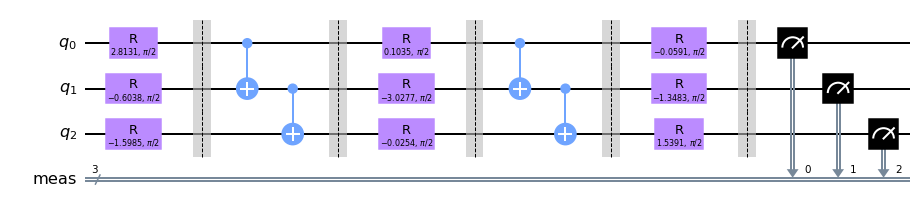

In [5]:
qc3 = QuantumCircuit(3)
qc=qc3.compose(student_network)
qc.assign_parameters(weights, inplace=True)

qc.measure_all()
qc.decompose().draw(output='mpl')

In [5]:
# #choosing the qasm simulator backend

# from qiskit.visualization import plot_histogram

# backend = Aer.get_backend('qasm_simulator')

# # running the job and getting results (counts)
# job = execute(qc, backend, shots=1024) # shots = no. of times you want to run the experiment
# result = job.result()
# counts = result.get_counts(qc)

# #printing and visualizing results (histogram data of experiment)
# print(counts)
# plot_histogram(counts)

In [7]:
from qiskit import QuantumCircuit, transpile, IBMQ
provider = IBMQ.load_account()

In [22]:
backend_overview()

ibm_oslo                     ibm_nairobi                  ibmq_manila
--------                     -----------                  -----------
Num. Qubits:  7              Num. Qubits:  7              Num. Qubits:  5
Pending Jobs: 8              Pending Jobs: 13             Pending Jobs: 4
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      140.8          Avg. T1:      121.9          Avg. T1:      152.5
Avg. T2:      98.7           Avg. T2:      53.3           Avg. T2:      58.2



ibmq_quito                   ibmq_belem                   ibmq_lima
----------                   ----------                   ---------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 1              Pending Jobs: 0              Pending Jobs: 3
Least busy:   False          Least busy:   True           Least busy:   False
Operational:  True           Operatio

In [11]:
backend=provider.get_backend('ibmq_belem')

In [12]:
#Execute the circuit on the backend
job=execute(qc,backend,shots=1024)

In [14]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [7]:
belem = provider.get_backend('ibmq_belem')

In [8]:
belem.jobs()

In [16]:
job = belem.retrieve_job('62e04f0d1813982a9ec6d48a')
result=job.result()
counts=result.get_counts()
histogram = plot_histogram(counts,title="Quantum Neural Network on IBMQ_Belem")
histogram.savefig('qnn_belem.pdf')

## Qiskit Runtime

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend('ibmq_belem')

In [23]:
backend

<IBMBackend('ibmq_belem')>

In [33]:
from qiskit_ibm_runtime import Sampler

with Sampler(circuits=qc, service=service,
             #options={'backend': backend},
             options={"backend": "ibmq_qasm_simulator"},
             #options={"backend": "ibmq_belem"},
             #skip_transpilation=True
            ) as sampler:
    result = sampler(circuits=[0], shots=8192)
    print(result)

SamplerResult(quasi_dists=[{'101': 0.000244140625, '001': 0.5968017578125, '011': 0.3533935546875, '010': 0.005859375, '000': 0.043701171875}], metadata=[{'header_metadata': {}, 'shots': 8192}])


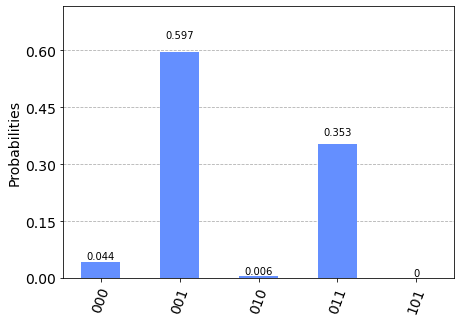

In [34]:
plot_histogram(result.quasi_dists)

In [21]:
histogram=plot_histogram(result.quasi_dists, title="QNN on Simulator, shots = 1024")
histogram.savefig('qnn_sim-1024.pdf')

In [32]:
histogram=plot_histogram(result.quasi_dists, title="QNN on IBMQ_Belem, shots = 8192")
histogram.savefig('qnn_belem-8192.pdf')